# Part 1
#### Importing libraries

In [1]:
import pytz
import torch
from PIL import Image
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.optim import SGD
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
from torch.utils.data import Dataset
import time
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
from torch.autograd import Variable
import numpy as np
from torch import optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_file = '/content/drive/MyDrive/Datasets/MMU-Iris-Database.zip'
extract_folder = '/content/'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Part 2
#### loading train and test data

In [4]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

In [6]:
# Load the training dataset
train_folder_dataset = datasets.ImageFolder(root="MMU-Iris-Database/train/")

# Initialize the network
train_siamese_dataset = SiameseNetworkDataset(imageFolderDataset=train_folder_dataset,
                                        transform=transformation)

train_dataloader = DataLoader(train_siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
print(len(train_dataloader))

6


In [8]:
# Load the training dataset
test_folder_dataset = datasets.ImageFolder(root="MMU-Iris-Database/test/")

# Initialize the network
test_siamese_dataset = SiameseNetworkDataset(imageFolderDataset=test_folder_dataset,
                                        transform=transformation)

test_dataloader = DataLoader(test_siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

In [9]:
print(len(test_dataloader))

2


In [10]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

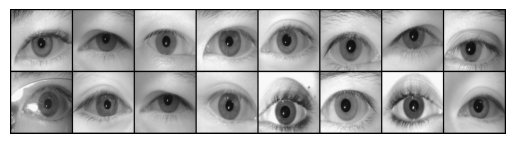

[1. 1. 1. 0. 1. 0. 1. 1.]


In [11]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(train_siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

# Part 3
#### Implementing CNN model

In [12]:
class SiameseModel(nn.Module):

    def __init__(self):
        super(SiameseModel, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [13]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

# Part 4
#### Creating an object from the model and Implementation of optimizer and loss function

In [14]:
# CNNmodel
model = SiameseModel()

# loss function
criterion = ContrastiveLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SiameseModel(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

# Part 5
#### Train Time

In [16]:
train_losses = []
validation_losses = []
best_epoch_number = 0

def train(early_stopping_patience=50):
    global best_epoch_number

    best_loss = float('inf')
    current_patience = 0
    best_model_state = None
    num_epochs = 200
    # Training loop
    for epoch in range(1, num_epochs):
        start_time = time.time()
        _train_losses = []
        for i, (img0, img1, labels) in enumerate(train_dataloader, 0):

            # Send the images and labels to CUDA
            img0, img1, labels = img0.cuda(), img1.cuda(), labels.cuda()

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = model(img0, img1)

            # Pass the outputs of the networks and label into the loss function
            loss_contrastive = criterion(output1, output2, labels)

            # Calculate the backpropagation
            loss_contrastive.backward()

            _train_losses.append(loss_contrastive.item())

            optimizer.step()

        # Calculate validation loss
        _validation_losses = []
        with torch.no_grad():
            for i, (img0, img1, labels) in enumerate(test_dataloader, 0):
                val_img0, val_img1, val_labels = img0.to(device), img1.to(device), labels.to(device)
                # forward + backward + optimize
                val_outputs0, val_outputs1 = model(val_img0, val_img1)
                val_loss = criterion(val_outputs0, val_outputs1, val_labels)
                _validation_losses.append(val_loss.item())

        avg_validation_loss = sum(_validation_losses) / len(_validation_losses)
        validation_losses.append(avg_validation_loss)

        if avg_validation_loss < best_loss:
            best_loss = avg_validation_loss
            best_epoch_number = epoch
            best_model_state = model.state_dict()
            current_patience = 0
        else: # when the network loss goes up
            current_patience += 1


        avg_loss = sum(_train_losses) / len(_train_losses)
        train_losses.append(avg_loss)

        # print statistics
        end_time = time.time()
        elapsed_time = end_time - start_time
        if epoch < 10:
            print(f'Epoch [{epoch:.2f}/{num_epochs}], Train Loss: {avg_loss:.6f} Validation Loss: {avg_validation_loss:.6f}, distance to Best val epoch number: {epoch - best_epoch_number}, Elapsed_time: {elapsed_time:.5f}')
        elif epoch <= 99 and epoch < 100:
            print(f'Epoch [{epoch:.1f}/{num_epochs}], Train Loss: {avg_loss:.6f} Validation Loss: {avg_validation_loss:.6f}, distance to Best val epoch number: {epoch - best_epoch_number}, Elapsed_time: {elapsed_time:.5f}')
        else:
            print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {avg_loss:.6f} Validation Loss: {avg_validation_loss:.6f}, distance to Best val epoch number: {epoch - best_epoch_number}, Elapsed_time: {elapsed_time:.5f}')

        if current_patience >= early_stopping_patience:
            print("Early stopping triggered.")
            model.load_state_dict(best_model_state)
            break
    model.load_state_dict(best_model_state)
    print('Finished Training')

In [17]:
train()

Epoch [1.00/200], Train Loss: 1.865115 Validation Loss: 1.449825, distance to Best val epoch number: 0, Elapsed_time: 3.40269
Epoch [2.00/200], Train Loss: 1.285774 Validation Loss: 1.218820, distance to Best val epoch number: 0, Elapsed_time: 1.21341
Epoch [3.00/200], Train Loss: 1.033140 Validation Loss: 0.937551, distance to Best val epoch number: 0, Elapsed_time: 1.19756
Epoch [4.00/200], Train Loss: 0.963548 Validation Loss: 1.118216, distance to Best val epoch number: 1, Elapsed_time: 1.18302
Epoch [5.00/200], Train Loss: 0.971433 Validation Loss: 1.163415, distance to Best val epoch number: 2, Elapsed_time: 2.00489
Epoch [6.00/200], Train Loss: 1.049700 Validation Loss: 0.925510, distance to Best val epoch number: 0, Elapsed_time: 2.16230
Epoch [7.00/200], Train Loss: 0.897559 Validation Loss: 0.988202, distance to Best val epoch number: 1, Elapsed_time: 1.23812
Epoch [8.00/200], Train Loss: 0.957975 Validation Loss: 1.234876, distance to Best val epoch number: 2, Elapsed_time: 

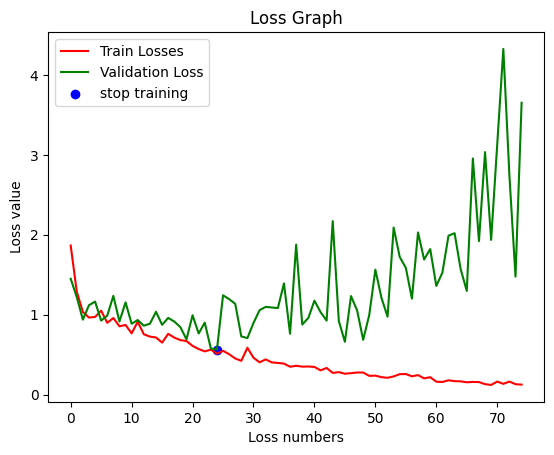

In [18]:
train_losses_number = list(range(len(train_losses)))
validation_losses_numbers = list(range(len(validation_losses)))

plt.plot(train_losses_number, train_losses, label='Train Losses', color='red')

# plot validation
plt.plot(validation_losses_numbers, validation_losses, label='Validation Loss', color='green')

plt.scatter([validation_losses.index(min(validation_losses))], validation_losses[validation_losses.index(min(validation_losses))], label="stop training" ,color="Blue",)

plt.xlabel('Loss numbers')
plt.ylabel('Loss value')
plt.title('Loss Graph')
plt.legend()

plt.show()

# Part 6
#### Saving model

In [19]:
# find Best epoch

print("Minimum Index position: ",validation_losses.index(min(validation_losses))+1,":",validation_losses[validation_losses.index(min(validation_losses))])

Minimum Index position:  25 : 0.5622166991233826


In [28]:
# saving the model
torch.save(model.state_dict(), 'model_3.pt')

In [29]:
# Load the saved weights
model = SiameseModel()
model.load_state_dict(torch.load('model_3.pt'))
model.to(device)

SiameseModel(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [30]:
import shutil
shutil.copy2('model_3.pt', '/content/drive/MyDrive/Weights/MMU-Iris-Database/model_3.pt')

'/content/drive/MyDrive/Weights/MMU-Iris-Database/model_3.pt'

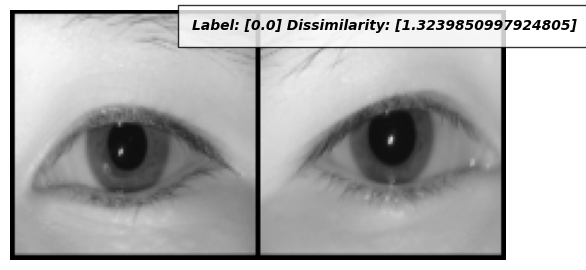

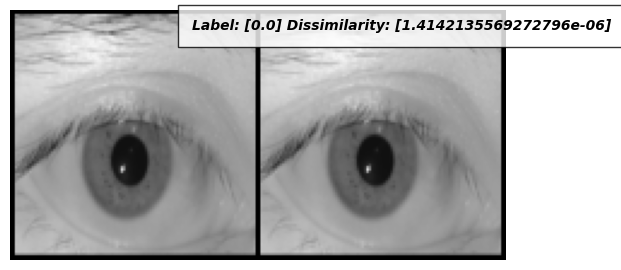

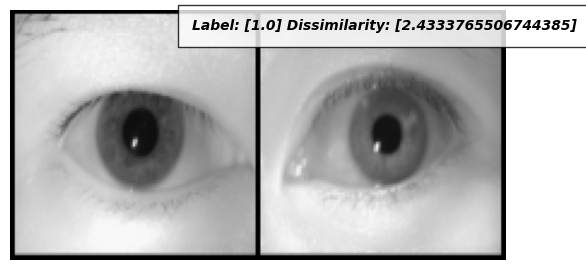

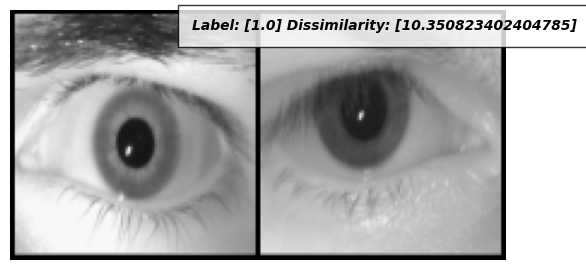

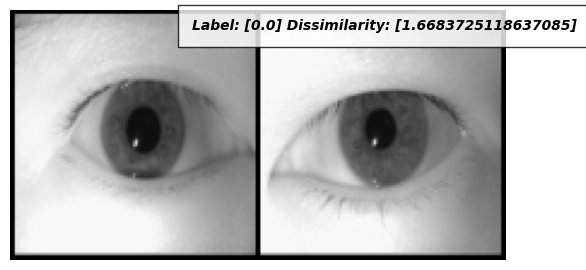

In [27]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="MMU-Iris-Database/test/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)

for i in range(5):
    # Iterate over 5 images and test them with the first image (x0)
    x0, x1, label = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = model(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Label: {label.tolist()[0]} Dissimilarity: {euclidean_distance.tolist()}')

In [40]:
# Define image transformations
transformation = transforms.Compose([
    # transforms.Grayscale(num_output_channels=3),
    transforms.Resize((100,100)),
    transforms.ToTensor()
])

# Load and preprocess two images
image_path1 = '105_7.tif'
image_path2 = '103_8.tif'

img1 = transformation(Image.open(image_path1).convert("L")).unsqueeze(0)
img2 = transformation(Image.open(image_path2).convert("L")).unsqueeze(0)

# Calculate the distance
with torch.no_grad():
    img1, img2 = img1.to(device), img2.to(device)
    output1, output2 = model(img1, img2)

    # Calculate the Euclidean distance
    euclidean_distance = F.pairwise_distance(output1, output2)

# Print the calculated distance
print(f"The Euclidean distance between the two images is: {euclidean_distance.item()}")

The Euclidean distance between the two images is: 0.02418620139360428


In [ ]:
exit()